In [ ]:
# %% [markdown]
# # Diabetes Prediction Model Pipeline
# In this notebook, we will build a robust pipeline to predict diabetes diagnosis using an ensemble model.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Data shape: (50000, 23)


,Age,Gender,Ethnicity,Income,BMI,Blood_Pressure,Cholesterol,Exercise_Hours_Per_Week,Alcohol_Consumption_Per_Week,Smoking_Status,...,Insulin_Resistance,Heart_Disease_History,Physical_Activity_Level,Fast_Food_Intake_Per_Week,Processed_Food_Intake_Per_Week,Daily_Caloric_Intake,Sleep_Hours_Per_Night,Stress_Level,Medication_Use,Diabetes_Diagnosis
0,69,Female,Other,39557,38.2,94.6,252.9,3.3,4,Never,...,5.1,0,Low,3,4,3641,8.7,Low,0,1
1,32,Male,Black,90663,33.6,167.0,282.6,4.6,7,Never,...,1.7,1,Moderate,8,0,3361,8.0,Low,1,0
2,89,Male,White,116180,39.4,100.6,106.8,6.1,5,Former,...,4.9,1,Low,9,8,2397,8.8,High,1,0
3,78,Male,Other,73059,40.6,111.1,169.7,7.4,9,Never,...,9.8,0,High,7,5,2491,6.4,Low,1,1
4,38,Female,White,35389,29.7,143.3,296.5,2.6,6,Never,...,1.7,1,Moderate,0,7,1325,6.6,High,1,0


                Age         Income           BMI  Blood_Pressure  \
count  50000.000000   50000.000000  50000.000000    50000.000000   
mean      53.398700   85176.555140     31.818748      135.080956   
std       20.799006   37574.185279      7.637138       26.039637   
min       18.000000   20000.000000     18.500000       90.000000   
25%       35.000000   52551.000000     25.200000      112.400000   
50%       53.000000   85355.500000     31.800000      135.200000   
75%       71.000000  117782.750000     38.400000      157.600000   
max       89.000000  149997.000000     45.000000      180.000000   

        Cholesterol  Exercise_Hours_Per_Week  Alcohol_Consumption_Per_Week  \
count  50000.000000             50000.000000                  50000.000000   
mean     200.185024                 4.991036                      7.004840   
std       57.737684                 2.882748                      4.324922   
min      100.000000                 0.000000                      0.000000 

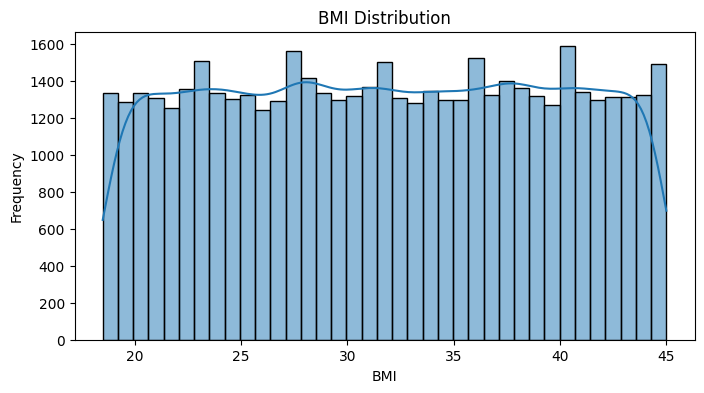

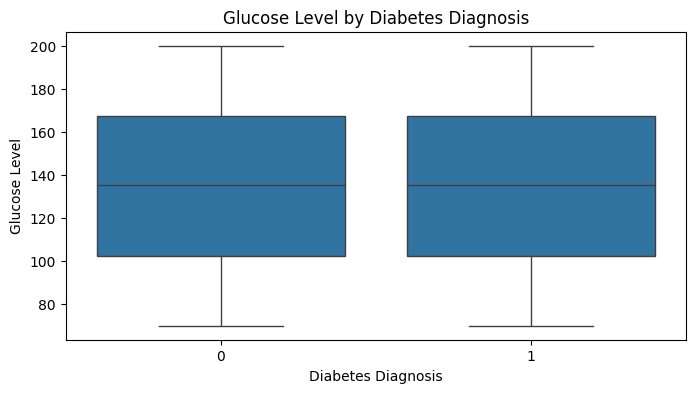

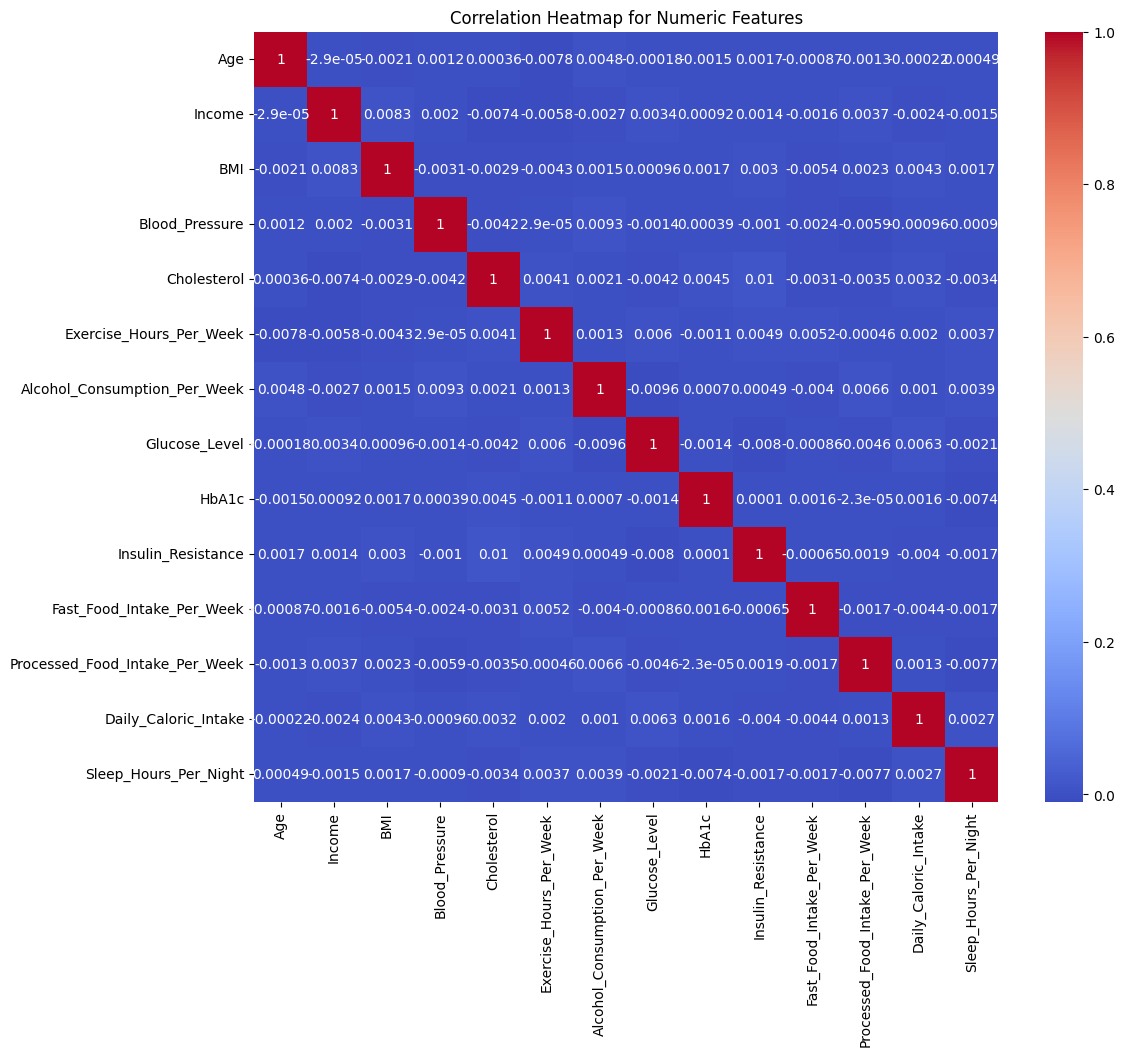

In [11]:

# %%
# Load the dataset
# Replace 'data.csv' with your actual data file path.
data = pd.read_csv('data/diabetes_dataset.csv')
print("Data shape:", data.shape)
display(data.head())

# %%
# Basic EDA
print(data.describe())
print(data.info())

# %% [markdown]
# ## Visualization

# %%
# Histogram for a numeric feature example (BMI)
plt.figure(figsize=(8, 4))
sns.histplot(data['BMI'], kde=True)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()

# %%
# Boxplot for Glucose_Level by Diabetes_Diagnosis
plt.figure(figsize=(8, 4))
sns.boxplot(x='Diabetes_Diagnosis', y='Glucose_Level', data=data)
plt.title("Glucose Level by Diabetes Diagnosis")
plt.xlabel("Diabetes Diagnosis")
plt.ylabel("Glucose Level")
plt.show()

# %%
# Correlation heatmap for numeric features
numeric_features = ['Age', 'Income', 'BMI', 'Blood_Pressure', 'Cholesterol', 
                    'Exercise_Hours_Per_Week', 'Alcohol_Consumption_Per_Week',
                    'Glucose_Level', 'HbA1c', 'Insulin_Resistance',
                    'Fast_Food_Intake_Per_Week', 'Processed_Food_Intake_Per_Week',
                    'Daily_Caloric_Intake', 'Sleep_Hours_Per_Night']
plt.figure(figsize=(12, 10))
corr = data[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

In [6]:

# %% [markdown]
# ## Data Preprocessing & Feature Engineering

# %%
# Identify target and features
target = 'Diabetes_Diagnosis'
X = data.drop(columns=[target])
y = data[target]

# Define numeric and categorical columns (adjust as necessary)
numeric_cols = ['Age', 'Income', 'BMI', 'Blood_Pressure', 'Cholesterol', 
                'Exercise_Hours_Per_Week', 'Alcohol_Consumption_Per_Week', 
                'Glucose_Level', 'HbA1c', 'Insulin_Resistance', 
                'Fast_Food_Intake_Per_Week', 'Processed_Food_Intake_Per_Week', 
                'Daily_Caloric_Intake', 'Sleep_Hours_Per_Night']
categorical_cols = ['Gender', 'Ethnicity', 'Smoking_Status', 'Family_History_Diabetes', 
                    'Heart_Disease_History', 'Physical_Activity_Level', 'Medication_Use']

# Example of feature engineering: creating a risk score
X['Risk_Score'] = X['BMI'] * X['Glucose_Level'] / 100.0
numeric_cols.append('Risk_Score')

# %%
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# %%
# Preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [9]:
# Define classification pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# %%
# Train the model
pipeline.fit(X_train, y_train)

# %%
# Evaluate the model

# Predictions
y_pred = pipeline.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC score
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.50      0.52      0.51      4979
           1       0.51      0.49      0.50      5021

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000

Confusion Matrix:
[[2591 2388]
 [2581 2440]]
ROC AUC Score: 0.5019038935846829


In [10]:

# %%
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier': [RandomForestClassifier(), XGBClassifier()],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# %%
# Evaluate the best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49      4979
           1       0.50      0.51      0.51      5021

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000

Confusion Matrix:
[[2442 2537]
 [2459 2562]]
ROC AUC Score: 0.49613895189111135


In [ ]:
rf_model = pipeline.named_steps['classifier']

# Extract feature names from the preprocessor
encoded_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, encoded_features])

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance using Random Forest")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), all_feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()